In [1]:
import os
import h5py
import cv2 # pip install opencv-python

import scipy.ndimage as sp
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import random
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from PIL import Image
from scipy.ndimage.filters import gaussian_filter

from keras.models import Sequential, Model, model_from_json
from keras.layers import Subtract, Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K 

%matplotlib inline

Using TensorFlow backend.


In [2]:
os.chdir('/Users/hyunwoogu/Dropbox/2019/2019Autumn/Graduation/ResearchGrant/experiment/stimuli')

In [3]:
for i in range(32):
    if i == 0:
        img_list = cv2.imread(str(i+1) + ".png", 1)
        img_list = cv2.resize(img_list, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        img_list = img_list[np.newaxis,:,:,:]
    else:
        im = cv2.imread(str(i+1) + ".png", 1)
        im = cv2.resize(im, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        im = im[np.newaxis,:,:,:]
        img_list = np.concatenate((img_list,im),axis=0)

In [4]:
os.chdir("/Users/hyunwoogu/Dropbox/2019/2019Autumn/Graduation/ResearchGrant/EyeModelRes")

In [5]:
par = pickle.load(open("par.pkl", 'rb')) # slightly modified parameter class from Masse

In [71]:
def rnn_cell_trial(rnn_input, h, var_dict, w_rnn):
    # no STSP
    h_post = h

    # Update the hidden state. Only use excitatory projections from input layer to RNN
    # All input and RNN activity will be non-negative
    h = np.maximum(h * (1-par['alpha_neuron'])
        + par['alpha_neuron'] * (rnn_input @ np.maximum(var_dict['w_in'],0)
        + h_post @ (w_rnn*par['w_rnn_mask']) + var_dict['b_rnn'])
        + np.random.normal(loc=0, scale=par['noise_rnn'], size=h.shape).astype(np.float32),0)

    return h

In [ ]:
h = np.maximum(h * (1-par['alpha_neuron'])
        + par['alpha_neuron'] * (rnn_input @ np.maximum(var_dict['w_in'],0)
        + h_post @ (w_rnn*par['w_rnn_mask']) + var_dict['b_rnn'])
        + np.random.normal(loc=0, scale=par['noise_rnn'], size=h.shape).astype(np.float32),0)

In [105]:
var_dict = weights
input_data = trial_info['neural_input']
w_rnn = weights['w_rnn']

In [136]:
i = 13
rnn_input = input_data[i]
rnn_input @ np.maximum(var_dict['w_in'],0)

array([[ 1.76211812e-01,  1.29615179e-01,  2.19165447e-01, ...,
         1.24210678e-02,  7.58713309e-01,  1.83309813e+00],
       [ 4.15008132e-02,  8.08573508e-02, -3.86215687e-02, ...,
         1.01070973e-02,  1.33520989e-02,  1.51856306e+00],
       [-1.84491597e-02, -1.17615718e-01,  5.14618717e-03, ...,
        -4.25947208e-02, -7.89171553e-02,  1.41023580e+00],
       ...,
       [-2.07930834e-02, -1.44414919e-01,  2.32883483e-01, ...,
        -2.88572832e-02, -4.91241772e-02,  1.40779912e+00],
       [ 1.72396491e-01,  1.73783861e-01,  2.20652513e-01, ...,
         1.76843248e-01, -7.34478681e-03,  1.44985825e+00],
       [-7.67932536e-04,  6.44161970e-02,  4.90777700e-03, ...,
         3.31925456e-02, -1.40168620e-02,  1.35506317e+00]])

In [131]:
rnn_input.shape

(512, 34)

In [115]:
h_post = h_

In [121]:
testtest = h_ * (1-par['alpha_neuron']) + par['alpha_neuron'] * (rnn_input @ np.maximum(var_dict['w_in'],0)
                                                                 + h_post @ (w_rnn*par['w_rnn_mask']) + var_dict['b_rnn']) + np.random.normal(loc=0, scale=par['noise_rnn'], size=h_.shape).astype(np.float32)

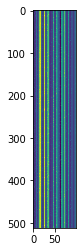

In [132]:
plt.imshow(testtest)

In [125]:
(h_ * (1-par['alpha_neuron'])).shape

(1, 100)

In [127]:
(par['alpha_neuron'] * (rnn_input @ np.maximum(var_dict['w_in'],0))).shape

(512, 100)

In [129]:
rnn_input.shape

(512, 34)

In [123]:
testtest.shape

(512, 100)

In [114]:
h = []
y = []
h_ = var_dict['h']

In [107]:
h_ = rnn_cell_trial(input_data[i], h_, var_dict, w_rnn)

In [112]:
var_dict['h'].shape

(1, 100)

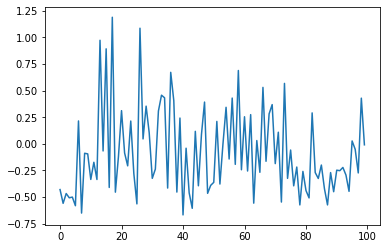

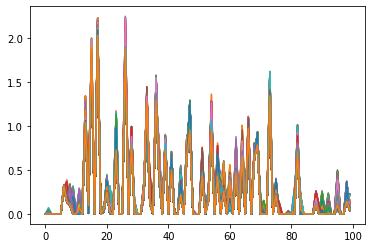

In [110]:
plt.plot(var_dict['h'].T)
plt.show()
plt.plot(h_.T)
plt.show()

In [111]:
h_.shape

(512, 100)

In [108]:
h_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.36976909,
        0.05133938],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15512169,
        0.22705994],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15128047,
        0.04847928],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.15605938,
        0.05194749],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15406824,
        0.04708053],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14393226,
        0.04655781]])

In [8]:
def run_model_trial(var_dict, w_rnn, input_data):
    # Main model loop
    h = []
    y = []
    h_ = var_dict['h']

    # Loop through the neural inputs to the RNN, indexed in time
    for i in range(len(input_data)):
        h_ = rnn_cell_trial(input_data[i], h_, var_dict, w_rnn)
        h.append(h_)
        y.append(h_ @ np.maximum(var_dict['w_out'],0) + var_dict['b_out'])
        
    h = np.stack(h)
    y = np.stack(y)

    return h, y

In [231]:
EI = np.ones(par['n_hidden'],dtype=np.float32)
EI[80:] *= -1 # inhibitory
RNNmask = 1-np.eye(par['n_hidden'],dtype=np.float32)
RNNmask = RNNmask @ np.diag(EI)

In [232]:
par['w_rnn_mask'] = RNNmask

In [229]:
par['w_in0'] = initialize([eyeTrial.n_input, par['n_hidden']], par['connection_prob'], shape=0.2, scale=1.)

# RNN weight


# Initial weights
par['w_out0']     = initialize([par['n_hidden'], 2], par['connection_prob'])
par['b_out0']     = np.zeros((1, 2), dtype=np.float32)

# Correction of initial values
par['w_rnn0'] *= par['w_rnn_mask']

NameError: name 'initialize' is not defined

In [10]:
import SeqTrial
eyeTrial = SeqTrial.Eye(test_mode=True)

In [11]:
par['noise_rnn'] = eyeTrial.noise_sd/10.

In [13]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [16]:
weights = pickle.load(open("final_weights.pkl", 'rb'))

In [44]:
res_y.shape

(100, 512, 2)

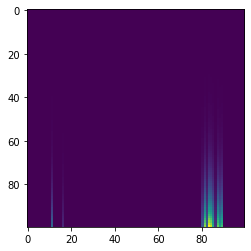

In [52]:
plt.imshow(res_h[:,80,:])

In [233]:
eyeTrial.discrim = 2
eyeTrial.condition = None

model = model_from_json(loaded_model_json)
model.load_weights("model.h5")
OPTIM = Adam()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

trial_info = eyeTrial.generate_trial(model, img_list)
res_h, res_y = run_model_trial(weights, weights['w_rnn'],trial_info['neural_input'])

RuntimeError: Attempted to use a closed Session.

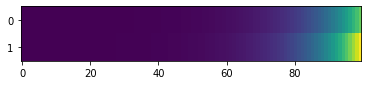

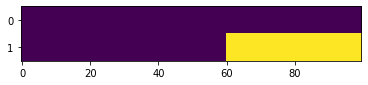

[2 3]
9
7


In [174]:
t = np.random.randint(eyeTrial.batchSize)

plt.figure(figsize = (6.1,1))
plt.imshow(res_y[:,t,:].T, aspect='auto')
plt.show()

plt.figure(figsize = (6.1,1))
plt.imshow(trial_info['desired_output'][:,t,:].T, aspect='auto')
plt.show()

print(trial_info['conditions'][t,:])
print(trial_info['sample_face'][t])
print(trial_info['test_face'][t])

In [177]:
var_dict = weights
w_rnn = var_dict['w_rnn']

In [175]:
def rnn_cell(rnn_input, h, var_dict, w_rnn):
    # no STSP
    h_post = h

    # Update the hidden state. Only use excitatory projections from input layer to RNN
    # All input and RNN activity will be non-negative
    h = tf.nn.relu(h * (1-par['alpha_neuron'])
        + par['alpha_neuron'] * (rnn_input @ tf.nn.relu(var_dict['w_in'])
        + h_post @ (w_rnn*par['w_rnn_mask']) + var_dict['b_rnn'])
        + tf.random_normal(h.shape, 0, par['noise_rnn'], dtype=tf.float32))

    return h

In [176]:
def run_model(var_dict, w_rnn, input_data):
    # Main model loop
    h = []
    y = []
    h_ = var_dict['h']

    # Loop through the neural inputs to the RNN, indexed in time
    for i in range(len(input_data)):
        h_ = rnn_cell(input_data[i], h_, var_dict, w_rnn)
        h.append(h_)
        y.append(h_ @ tf.nn.relu(var_dict['w_out']) + var_dict['b_out'])
        
    h = tf.stack(h)
    y = tf.stack(y)

    return h, y

In [321]:
mask = np.zeros([eyeTrial.numSteps, eyeTrial.batchSize])
# mask[eyeTrial.rg_test,:] = 1.
mask[:,:] = 1.

In [323]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['input', 'mask', 'target', 'unstack']

In [330]:
model_summ = np.zeros((8,4,4))

In [337]:
model_summ[0,:,:]

array([[0.56289062, 0.58125   , 0.56513672, 0.56264648],
       [0.57333984, 0.55463867, 0.57304687, 0.58242187],
       [0.5690918 , 0.55727539, 0.56479492, 0.55830078],
       [0.56967773, 0.56206055, 0.56469727, 0.53608398]])

In [590]:
for d in range(8):
    for f in range(4):
        for s in range(4):
            if ((d==0) & (f==0) & (s==0)):
                rnn_acc2 = pd.DataFrame({"Angular Difference":[(d+9)/32*360], "Condition":"position", "Mean Accuracy":[model_summ2[d,f,s]]})
            else:
                if (f==s):
                    rnn_acc2 = rnn_acc2.append(pd.DataFrame({"Angular Difference":[(d+9)/32*360], "Condition":"position", "Mean Accuracy":[model_summ2[d,f,s]]}))
                else:
                    rnn_acc2 = rnn_acc2.append(pd.DataFrame({"Angular Difference":[(d+9)/32*360], "Condition":"path", "Mean Accuracy":[model_summ2[d,f,s]]}))

In [595]:
rnn_accs = rnn_acc.append(rnn_acc2)

In [597]:
rnn_accs.shape

(256, 3)

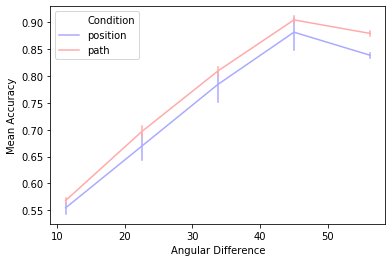

In [494]:
sns.lineplot(x="Angular Difference", y="Mean Accuracy", hue="Condition", data=rnn_acc, err_style="bars", palette=sns.color_palette('bwr', n_colors=2))
plt.show()

In [ ]:
model_summ

In [583]:
os.getcwd()

'/Users/hyunwoogu/Dropbox/2019/2019Autumn/Graduation/ResearchGrant/EyeModelRes'

In [598]:
rnn_accs.to_csv("psychometric3.csv", sep='\t', encoding='utf-8')

In [ ]:
for f in example_faces:
    for iterr in range(100):
        curr_fix = centL + np.random.choice(range(100),size=(2),replace=True)
        predict_res  = model.predict(getAttention2(np.flip(curr_fix),img=img_list[f]).reshape((1,40,40,1))).reshape((32,))
        predict_res /= np.linalg.norm(predict_res)
        if (f==0 & iterr==0):
            cnn_summ = pd.DataFrame({"Face Degree":np.arange(32)/32*360, "Face":f/32*360, "Probability(normalized)":predict_res})
        else:
            cnn_summ = cnn_summ.append(pd.DataFrame({"Face Degree":np.arange(32)/32*360, "Face":f/32*360, "Probability(normalized)":predict_res}))

In [ ]:
plt.figure(figsize = (10,6))
sns.lineplot(x="Face Degree", y="Probability(normalized)", hue="Face", data=cnn_summ, palette=sns.color_palette('gist_rainbow', n_colors=8), legend=False)
plt.show()

In [ ]:
, vmin=0.5, vmax=0.62

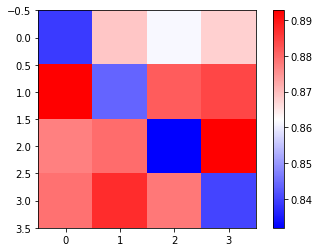

In [492]:
plt.imshow(model_summ[4,:,:], cmap="bwr")
plt.colorbar()

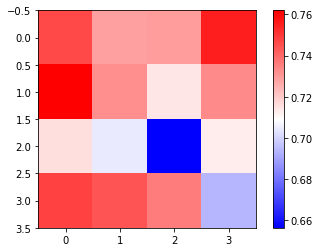

In [384]:
plt.imshow(model_summ2[7,:,:], cmap="bwr")
plt.colorbar()

### Decoding

In [389]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
svm_classifier = SVC(gamma='auto')
svr_predictor  = SVR(gamma='scale', C=1.0, epsilon=0.2)
n_cv = 32

In [399]:
DM_groundtruth = trial_info['desired_output_DM'][:,:,0]
Estim_groundtruth = trial_info['desired_output_Estim'][:,:,0]

In [504]:
DM_groundtruth_centcent  = np.zeros((100,512))
DM_groundtruth_centperi  = np.zeros((100,512))
DM_groundtruth_pericent  = np.zeros((100,512))
DM_groundtruth_periperi  = np.zeros((100,512))

for t in range(512):
    DM_groundtruth_centcent[:,t]  = trial_info_centcent['desired_output'][eyeTrial.rg_test[0],t,0]
    DM_groundtruth_centperi[:,t]  = trial_info_centperi['desired_output'][eyeTrial.rg_test[0],t,0]
    DM_groundtruth_pericent[:,t]  = trial_info_pericent['desired_output'][eyeTrial.rg_test[0],t,0]
    DM_groundtruth_periperi[:,t]  = trial_info_periperi['desired_output'][eyeTrial.rg_test[0],t,0]

In [529]:
trial_info_centcent['sample_face'].shape

(512,)

In [ ]:
sample_groundtruth_centcent  = np.zeros(512)
sample_groundtruth_centperi  = np.zeros(512)
sample_groundtruth_pericent  = np.zeros(512)
sample_groundtruth_periperi  = np.zeros(512)

for t in range(512):
    DM_groundtruth_centcent[:,t]  = trial_info_centcent['sample_face'][t]
    DM_groundtruth_centperi[:,t]  = trial_info_centperi['sample_face'][eyeTrial.rg_test[0],t,0]
    DM_groundtruth_pericent[:,t]  = trial_info_pericent['sample_face'][eyeTrial.rg_test[0],t,0]
    DM_groundtruth_periperi[:,t]  = trial_info_periperi['sample_face'][eyeTrial.rg_test[0],t,0]

In [520]:
new_conds = np.repeat(np.repeat(["position","path","position"],[n_cv,n_cv*2,n_cv]),eyeTrial.numSteps)

In [527]:
DM_groundtruth_centcent[:,:][0,:].shape

(512,)

In [585]:
sampleCV_agg.to_csv("sample_decoding.csv", sep='\t', encoding='utf-8')

In [586]:
testCV_agg.to_csv("test_decoding.csv", sep='\t', encoding='utf-8')

In [ ]:
sampleCV_agg

In [532]:
n_cv = 4
for t in range(eyeTrial.numSteps):
    CV_centcent  = cross_val_score(svm_classifier, res_h_centcent[t,:,:], trial_info_centcent['sample_face'], cv=4)
    CV_centperi  = cross_val_score(svm_classifier, res_h_centperi[t,:,:], trial_info_centperi['sample_face'], cv=4)
    CV_pericent  = cross_val_score(svm_classifier, res_h_pericent[t,:,:], trial_info_pericent['sample_face'], cv=4)
    CV_periperi  = cross_val_score(svm_classifier, res_h_periperi[t,:,:], trial_info_periperi['sample_face'], cv=4)
    
    CVCV = np.concatenate((CV_centcent,CV_centperi,CV_pericent,CV_periperi))
    time_ind = np.repeat(list(range(eyeTrial.numSteps))[t],n_cv*4)
    hypo_ind = np.repeat(["position","path","path","position"],[n_cv,n_cv,n_cv,n_cv])
    if (t==0):
        sampleCV_agg = pd.DataFrame({"Time":time_ind, "Condition":hypo_ind, "CVperformance":CVCV})
    else:
        sampleCV_agg = sampleCV_agg.append(pd.DataFrame({"Time":time_ind, "Condition":hypo_ind, "CVperformance":CVCV}))

In [603]:
eyeTrial.rg_samFix2

array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

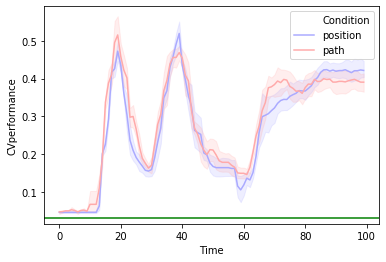

In [540]:
sns.lineplot(x="Time", y="CVperformance", hue="Condition", data=sampleCV_agg, palette=sns.color_palette('bwr', n_colors=2))
plt.axhline(y=1/32, color='g', linestyle='-')
plt.show()

In [534]:
n_cv = 4
for t in range(eyeTrial.numSteps):
    CV_centcent  = cross_val_score(svm_classifier, res_h_centcent[t,:,:], trial_info_centcent['test_face'], cv=4)
    CV_centperi  = cross_val_score(svm_classifier, res_h_centperi[t,:,:], trial_info_centperi['test_face'], cv=4)
    CV_pericent  = cross_val_score(svm_classifier, res_h_pericent[t,:,:], trial_info_pericent['test_face'], cv=4)
    CV_periperi  = cross_val_score(svm_classifier, res_h_periperi[t,:,:], trial_info_periperi['test_face'], cv=4)
    
    CVCV = np.concatenate((CV_centcent,CV_centperi,CV_pericent,CV_periperi))
    time_ind = np.repeat(list(range(eyeTrial.numSteps))[t],n_cv*4)
    hypo_ind = np.repeat(["position","path","path","position"],[n_cv,n_cv,n_cv,n_cv])
    if (t==0):
        testCV_agg = pd.DataFrame({"Time":time_ind, "Condition":hypo_ind, "CVperformance":CVCV})
    else:
        testCV_agg = testCV_agg.append(pd.DataFrame({"Time":time_ind, "Condition":hypo_ind, "CVperformance":CVCV}))

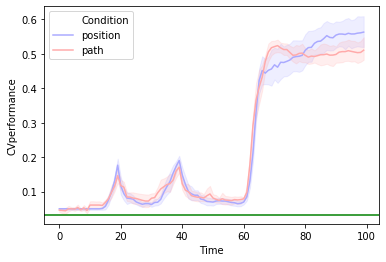

In [537]:
sns.lineplot(x="Time", y="CVperformance", hue="Condition", data=testCV_agg, palette=sns.color_palette('bwr', n_colors=2))
plt.axhline(y=1/32, color='g', linestyle='-')
plt.show()

In [513]:
new_condition = []

In [ ]:
for i in range(12800):
    

In [511]:
new_condition.append("new")

In [519]:
new_conds.shape

(108800,)

In [521]:
CV_agg.Condition = new_conds

In [599]:
eyeTrial.rg_test

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99])

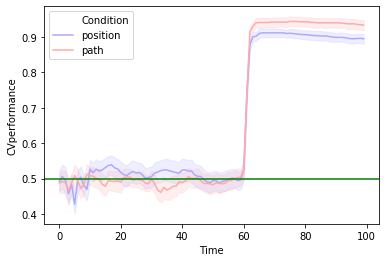

In [536]:
sns.lineplot(x="Time", y="CVperformance", hue="Condition", data=CV_agg, palette=sns.color_palette('bwr', n_colors=2))
plt.axhline(y=0.5, color='g', linestyle='-')
plt.show()

In [587]:
CV_agg.to_csv("groundtruth_decoding.csv", sep='\t', encoding='utf-8')

In [545]:
centcent_pca = np.zeros((eyeTrial.numSteps,eyeTrial.batchSize,3))
centperi_pca = np.zeros((eyeTrial.numSteps,eyeTrial.batchSize,3))
pericent_pca = np.zeros((eyeTrial.numSteps,eyeTrial.batchSize,3))
periperi_pca = np.zeros((eyeTrial.numSteps,eyeTrial.batchSize,3))

In [546]:
for t in range(eyeTrial.numSteps):
    centcent_pca[t,:,:] = pca3.fit_transform(res_h_centcent[t,:,:])
    centperi_pca[t,:,:] = pca3.fit_transform(res_h_centperi[t,:,:])
    pericent_pca[t,:,:] = pca3.fit_transform(res_h_pericent[t,:,:])
    periperi_pca[t,:,:] = pca3.fit_transform(res_h_periperi[t,:,:])

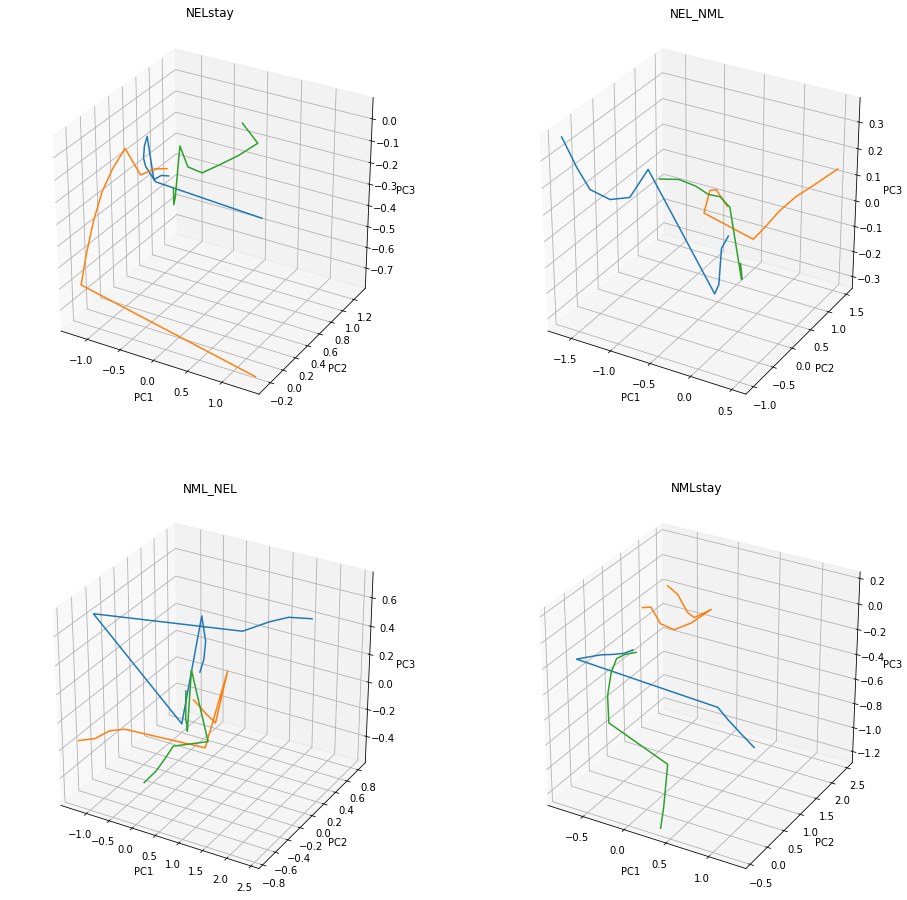

In [551]:
time_rg = range(10,20)

fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
for tr in range(3):
    ax.plot(centcent_pca[time_rg,tr,0], centcent_pca[time_rg,tr,1], centcent_pca[time_rg,tr,2])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NELstay")

ax = fig.add_subplot(2, 2, 2, projection='3d')
for tr in range(3):
    ax.plot(centperi_pca[time_rg,tr,0], centperi_pca[time_rg,tr,1], centperi_pca[time_rg,tr,2])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NEL_NML")
    
ax = fig.add_subplot(2, 2, 3, projection='3d')
for tr in range(3):
    ax.plot(pericent_pca[time_rg,tr,0], pericent_pca[time_rg,tr,1], pericent_pca[time_rg,tr,2])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NML_NEL")

ax = fig.add_subplot(2, 2, 4, projection='3d')
for tr in range(3):
    ax.plot(periperi_pca[time_rg,tr,0], periperi_pca[time_rg,tr,1], periperi_pca[time_rg,tr,2])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NMLstay")
    
plt.show()

In [565]:
eyeTrial.rg_test

 + list(eyeTrial.rg_samFix2)

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99])

In [ ]:
res

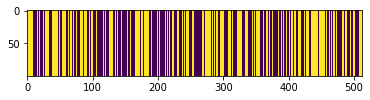

In [606]:
plt.imshow(DM_groundtruth_centcent)

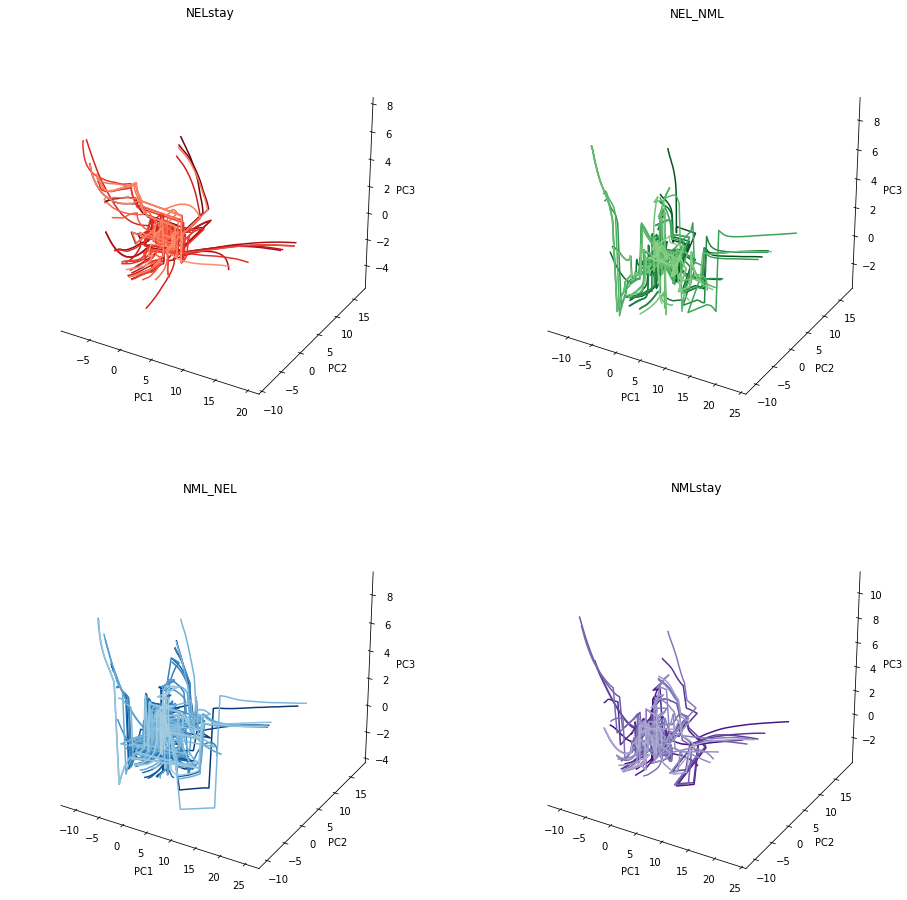

In [679]:
n = 80
time_rg = list(eyeTrial.rg_test)
colors_red = plt.cm.Reds_r(np.linspace(0,1,n))
colors_green = plt.cm.Greens_r(np.linspace(0,1,n))
colors_blue = plt.cm.Blues_r(np.linspace(0,1,n))
colors_purple = plt.cm.Purples_r(np.linspace(0,1,n))

fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
for tr in range(50):
    ax.plot(centcent_pca[time_rg,tr,0], centcent_pca[time_rg,tr,1], centcent_pca[time_rg,tr,2], color=colors_red[tr])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NELstay")
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    
colors_green = plt.cm.Greens_r(np.linspace(0,1,80))
ax = fig.add_subplot(2, 2, 2, projection='3d')
for tr in (list(range(5,20)) + list(range(20,30)) + list(range(60,80))):
    if tr == 5:
        i = 1;
    else:
        i += 1
    ax.plot(centperi_pca[time_rg,tr,0], centperi_pca[time_rg,tr,1], centperi_pca[time_rg,tr,2], color=colors_green[i])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NEL_NML")
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

colors_blue = plt.cm.Blues_r(np.linspace(0,1,110))
ax = fig.add_subplot(2, 2, 3, projection='3d')
for tr in (list(range(70,110)) + list(range(120,150))):
    if tr == 70:
        i = 1;
    else:
        i += 1
    ax.plot(pericent_pca[time_rg,tr,0], pericent_pca[time_rg,tr,1], pericent_pca[time_rg,tr,2], color=colors_blue[i])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NML_NEL")
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    
colors_purple = plt.cm.Purples_r(np.linspace(0,1,80))
ax = fig.add_subplot(2, 2, 4, projection='3d')
for tr in np.flip(list(range(10,40)) + list(range(125,140))):
    if tr == 139:
        i = 1;
    else:
        i += 1
    ax.plot(periperi_pca[time_rg,tr,0], periperi_pca[time_rg,tr,1], periperi_pca[time_rg,tr,2], color=colors_purple[i])
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3");
    ax.title.set_text("NMLstay")
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    
plt.show()

In [ ]:
n_cv = 32
for t in range(eyeTrial.numSteps):
    CV_pos  = cross_val_score(svm_classifier, res_h_pos[t,:,:], DM_groundtruth_pos[:,:][t,:], cv=32)
    CV_path = cross_val_score(svm_classifier, res_h_path[t,:,:], DM_groundtruth_path[:,:][t,:], cv=32)
    CV_res = np.concatenate((CV_pos,CV_path))
    time_ind = np.repeat(list(range(eyeTrial.numSteps))[t],n_cv*2)
    hypo_ind = np.repeat(["Position","Path"],[n_cv,n_cv])
    if (t==0):
        CV = pd.DataFrame({"Time":time_ind, "Hypothesis":hypo_ind, "CV":CV_res})
    else:
        CV = CV.append(pd.DataFrame({"Time":time_ind, "Hypothesis":hypo_ind, "CV":CV_res}))
        
sns.lineplot(x="Time", y="CV", hue="Hypothesis", data=CV)
plt.show()

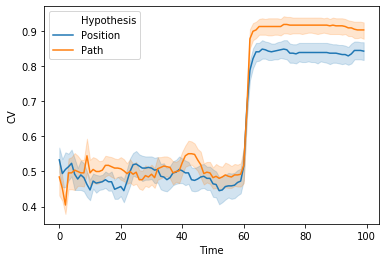

In [406]:
n_cv = 32
for t in range(eyeTrial.numSteps):
    CV_pos  = cross_val_score(svm_classifier, res_h_pos[t,:,:], DM_groundtruth_pos[:,:][t,:], cv=32)
    CV_path = cross_val_score(svm_classifier, res_h_path[t,:,:], DM_groundtruth_path[:,:][t,:], cv=32)
    CV_res = np.concatenate((CV_pos,CV_path))
    time_ind = np.repeat(list(range(eyeTrial.numSteps))[t],n_cv*2)
    hypo_ind = np.repeat(["Position","Path"],[n_cv,n_cv])
    if (t==0):
        CV = pd.DataFrame({"Time":time_ind, "Hypothesis":hypo_ind, "CV":CV_res})
    else:
        CV = CV.append(pd.DataFrame({"Time":time_ind, "Hypothesis":hypo_ind, "CV":CV_res}))
        
sns.lineplot(x="Time", y="CV", hue="Hypothesis", data=CV)
plt.show()

In [374]:
model_summ2 = np.zeros((8,4,4))

In [501]:
eyeTrial.discrim = 4
eyeTrial.condition = [1,1]

tf.reset_default_graph()  # reset graphs in background
x = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize,eyeTrial.n_input], 'input')
m = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize], 'mask')
t = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize,2], 'target')

input_data  = tf.unstack(x, axis=0)
target_data = t
h, y = run_model(var_dict, w_rnn, input_data)
with tf.Session(graph=tf.get_default_graph()) as sess: 
    sess.run(tf.global_variables_initializer())
    K.set_session(sess)
    model = model_from_json(loaded_model_json)
    model.load_weights("model.h5")
    OPTIM = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

    trial_info = eyeTrial.generate_trial(model, img_list)
    res_y_path, res_h_path = sess.run([y, h],
                            feed_dict = {x: trial_info['neural_input'],   # neural_input 
                                         t: trial_info['desired_output'], # desired_output
                                         m: mask}) # train_mask

In [502]:
trial_info_periperi = trial_info
res_y_periperi = res_y_path
res_h_periperi = res_h_path

In [407]:
target_res = trial_info['desired_output'][eyeTrial.rg_test,:,:]
our_res = res_y[eyeTrial.rg_test,:,:]

In [416]:
target_res.shape

(40, 512, 2)

In [409]:
target_res.shape

(40, 512, 2)

In [422]:
test_row_sums

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.5273430e-01, 2.4659371e-01,
       6.3946735e+01, 1.2506046e-03, 1.7270029e+01, 8.3657021e+01,
       0.0000000e+00, 1.7228763e+00, 0.0000000e+00, 1.6546796e+02,
       0.0000000e+00, 1.9128683e+01, 0.0000000e+00, 4.4071116e-02,
       2.9245895e-01, 5.9160247e-02, 0.0000000e+00, 1.1845819e+00,
       0.0000000e+00, 0.0000000e+00, 6.9847565e+01, 6.6739714e-01,
       2.6382938e+02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.9947520e-01, 8.4679047e+01, 1.2082812e-01, 0.0000000e+00,
       6.3796778e+00, 4.3743795e-01, 0.0000000e+00, 1.7111362e+02,
       0.0000000e+00, 7.4290162e-01, 0.0000000e+00, 0.0000000e+00,
       5.6407750e-03, 0.0000000e+00, 4.3869816e+01, 1.7692693e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.9546206e-01,
       0.0000000e+00, 2.5390816e-01, 8.1375854e+01, 0.0000000e+00,
       6.9064128e-01, 1.1652361e-01, 1.8553591e-01, 0.0000000e

[0 1]


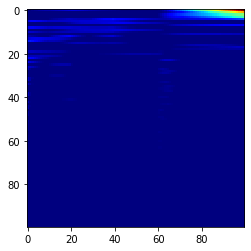

In [442]:
t = np.random.randint(eyeTrial.batchSize)

test_res_h = res_h_path[:,t,:].T
test_res_h_row_mean = np.mean(test_res_h, axis=1)
plt.imshow(test_res_h[np.flip(np.argsort(test_res_h_row_mean)),:], cmap="jet")

print(trial_info['conditions'][t])

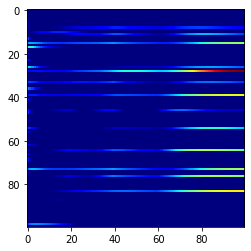

In [415]:
plt.imshow(res_h_path[:,3,:].T, cmap='jet')

In [ ]:
get_accuracy(trial_info['desired_output'][eyeTrial.rg_test,:,:], res_y[eyeTrial.rg_test,:,:])

In [375]:
for d in range(8):
    for f in range(4):
        for s in range(4):
            eyeTrial.discrim = d + 9
            eyeTrial.condition = [f,s]

            tf.reset_default_graph()  # reset graphs in background
            x = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize,eyeTrial.n_input], 'input')
            m = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize], 'mask')
            t = tf.placeholder(tf.float32, [eyeTrial.numSteps, eyeTrial.batchSize,2], 'target')

            input_data  = tf.unstack(x, axis=0)
            target_data = t
            h, y = run_model(var_dict, w_rnn, input_data)
            with tf.Session(graph=tf.get_default_graph()) as sess: 
                sess.run(tf.global_variables_initializer())
                K.set_session(sess)
                model = model_from_json(loaded_model_json)
                model.load_weights("model.h5")
                OPTIM = Adam()
                model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

                trial_info = eyeTrial.generate_trial(model, img_list)
                res_y, res_h = sess.run([y, h],
                                        feed_dict = {x: trial_info['neural_input'],   # neural_input 
                                                     t: trial_info['desired_output'], # desired_output
                                                     m: mask}) # train_mask

            model_summ2[d,f,s] = get_accuracy(trial_info['desired_output'][eyeTrial.rg_test,:,:], res_y[eyeTrial.rg_test,:,:])

Exception ignored in: <function BaseSession._Callable.__del__ at 0x1a36372598>
Traceback (most recent call last):
  File "/Users/hyunwoogu/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <function BaseSession._Callable.__del__ at 0x1a36372598>
Traceback (most recent call last):
  File "/Users/hyunwoogu/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <function BaseSession._Callable.__del__ at 0x1a36372598>
Traceback (most recent call last):
  File "/Users/hyunwoogu/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._s

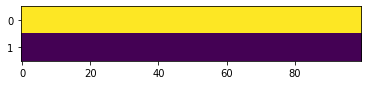

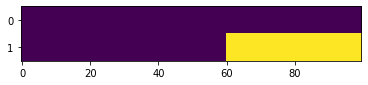

[3 1]
13
11


In [326]:
t = np.random.randint(eyeTrial.batchSize)

plt.figure(figsize = (6.1,1))
plt.imshow(res_y[:,t,:].T, aspect='auto')
plt.show()

plt.figure(figsize = (6.1,1))
plt.imshow(trial_info['desired_output'][:,t,:].T, aspect='auto')
plt.show()

print(trial_info['conditions'][t,:])
print(trial_info['sample_face'][t])
print(trial_info['test_face'][t])

In [327]:
def get_accuracy(target, output):
    # Calculate argmax along the last dimension
    target_max = np.argmax(target, axis = 2)
    output_max = np.argmax(output, axis = 2)
    # Calculate 2D "average" of match between target_max & output_max 
    accuracy = np.sum(np.float32(target_max == output_max))/np.sum(np.ones(output_max.shape))
    return accuracy

0.705419921875